In [13]:
from qiskit import IBMQ, pulse, assemble
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform
from qiskit.pulse.library import drag
from qiskit.visualization import plot_gate_map, plot_error_map
import numpy as np
import matplotlib.pyplot as plt
from qiskit.pulse.library.parametric_pulses import GaussianSquare

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider_opts = {'hub': 'ibm-q-ncsu', 'group': 'nc-state', 'project':'noiseanderror'}
provider = IBMQ.get_provider(**provider_opts)
backend = provider.get_backend('ibmq_guadalupe')
config = backend.configuration()
defaults = backend.defaults()
inst_map = defaults.instruction_schedule_map
dt = config.dt

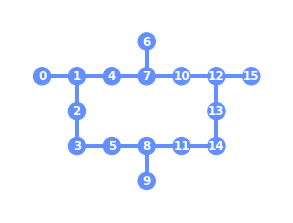

In [4]:
plot_gate_map(backend)

In [5]:
meas = inst_map.get('measure', qubits=range(config.n_qubits))
# meas.exclude(channels=[pulse.AcquireChannel(i) 
#                         for i in range(config.n_qubits)]).draw()

In [6]:
def get_cx_schedule(backend, qc, qt):
    if [qc, qt] not in backend.configuration().coupling_map:
        print(F"No direct coupling between {qc} and {qt}")
    else:
        cx_sched = backend.defaults().instruction_schedule_map.get("cx", [qc, qt])
        return cx_sched
    
def get_cr_cancel_pulses(backend, qc, qt):
    cx_sched = get_cx_schedule(backend, qc, qt)
    cancel_pulses = []
    cr_pulses = []
    for time, inst in cx_sched.instructions:
        if isinstance(inst, Play):
            if isinstance(inst.pulse, GaussianSquare):
                if isinstance(inst.operands[1], DriveChannel):
                    cancel_pulses.append((GaussianSquare(duration=inst.pulse.duration,
                                                      amp=inst.pulse.amp,
                                                      sigma=inst.pulse.sigma,
                                                      width=inst.pulse.width,
                                                      name=inst.pulse.name), inst.channel))
                if isinstance(inst.operands[1], ControlChannel):
                    cr_pulses.append((GaussianSquare(duration=inst.pulse.duration,
                                                      amp=inst.pulse.amp,
                                                      sigma=inst.pulse.sigma,
                                                      width=inst.pulse.width,
                                                      name=inst.pulse.name), inst.channel))
    return cancel_pulses[0][0], cr_pulses[0][0]



In [7]:
cancel_pulse, cr_pulse = get_cr_cancel_pulses(backend, 7, 4)
cr_amp = cr_pulse.get_waveform().samples[len(cr_pulse.get_waveform().samples)//2]
cr_dur = cr_pulse.duration
cr_width = cr_pulse.width
cr_risefall = (cr_dur - cr_width)/2

cancel_amp = cancel_pulse.get_waveform().samples[len(cancel_pulse.get_waveform().samples)//2]
cancel_dur = cancel_pulse.duration
cancel_width = cancel_pulse.width
cancel_risefall = (cancel_dur - cancel_width)/2

print(F"CR AMP: {cr_amp}\n CR DURATION: {cr_dur}\n CR WIDTH {cr_width}\n \
CR RISEFALL {cr_risefall}\n CANCEL AMP: {cancel_amp}\n \
CANCEL DURATION: {cancel_dur}\n CANCEL WIDTH: {cancel_width}\n CANCEL RISEFALL: {cancel_risefall}")

CR AMP: (0.43821127219626976-0.03065556602832589j)
 CR DURATION: 912
 CR WIDTH 656
 CR RISEFALL 128.0
 CANCEL AMP: (0.03256160098564643+0.003712445267449513j)
 CANCEL DURATION: 912
 CANCEL WIDTH: 656
 CANCEL RISEFALL: 128.0


In [8]:
# def build_cr_pulse(qc: int, qt: int, width: int, control='0', basis='Z', phase=0.0, framechange=0.0):
    


def build_cr_experiments(qc: int, qt: int, cr_times, phase=0.0, ZI_MHz=0.0):
    scheds = []
    for width in cr_times:
        framechange = 2*np.pi*int(width)*dt*ZI_MHz*1e6
        for basis in ['X', 'Y', 'Z']:
            for control in ['0', '1']:
#                 print(width, framechange, basis, control)
                duration = 0
                with pulse.build(backend=backend,name="CR width %i" %width) as sched:          
                    echo_x = inst_map.get('x', qubits=qc).instructions[0][1].pulse
                    cancel_dur = int(width + 2*cancel_risefall)
                    cr_dur = int(width+2*cr_risefall)
                    pulse.play(echo_x, DriveChannel(qc))
                    duration += echo_x.duration
                    pulse.delay(duration, config.drive(qt))
                    pulse.delay(duration, config.control((qc,qt))[0])
                    pulse.play(GaussianSquare(duration=cancel_dur, amp=cancel_amp, sigma=cancel_risefall//2, width=width), config.drive(qt))
                    pulse.play(GaussianSquare(duration=cr_dur, amp=cr_amp, sigma=cr_risefall//2, width=width), config.control((qc,qt))[0])
                    duration = cr_dur
                    pulse.delay(duration, config.drive(qc))
                    pulse.play(echo_x, DriveChannel(qc))
                    duration = echo_x.duration
                    pulse.delay(duration, config.control((qc,qt))[0])
                    pulse.delay(duration, config.drive(qt))
                    pulse.play(GaussianSquare(duration=cr_dur, amp=-cr_amp, sigma=cr_risefall//2, width=width), config.control((qc,qt))[0])
                    pulse.play(GaussianSquare(duration=cancel_dur, amp=-cancel_amp, sigma=cancel_risefall//2, width=width), config.drive(qt))
                    duration = (cr_dur*2)+(duration*2)
                    pulse.delay(duration, config.measure(qc))
                    pulse.measure((qc, qt))
                scheds.append(sched)
    return scheds

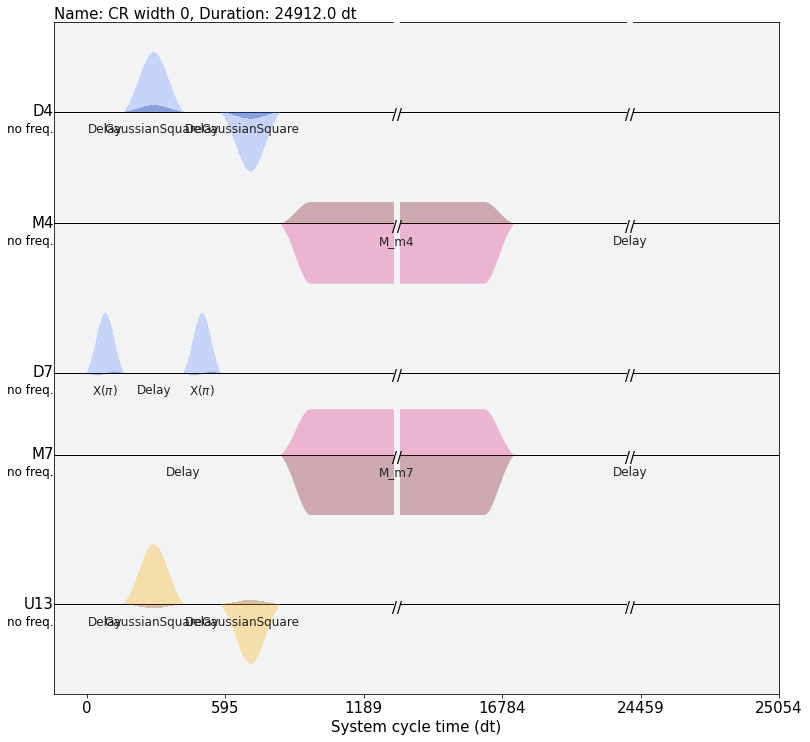

In [9]:
qc = 7
qt = 4
cr_times = 16*np.linspace(0, 500, 21)
scheds = build_cr_experiments(qc, qt, cr_times)
scheds[0].draw()

In [11]:
cr_amp = -cr_pulse.get_waveform().samples[len(cr_pulse.get_waveform().samples)//2]
cr_dur = cr_pulse.duration
cr_risefall = 128 # guess
cr_width = cr_dur - 2*cr_risefall
my_cr_pulse = GaussianSquare(duration=cr_dur, amp=cr_amp, sigma=cr_risefall//2, width=cr_width)

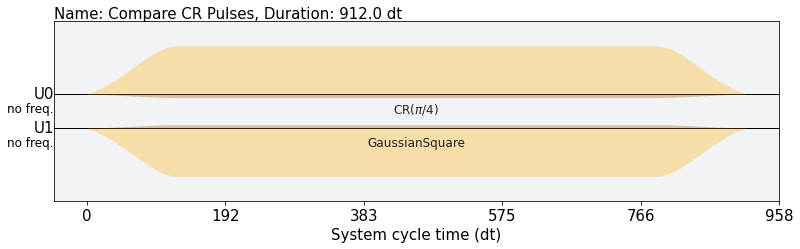

In [12]:
with pulse.build(name="Compare CR Pulses") as cr_test_sched:
    pulse.play(cr_pulse, ControlChannel(0))
    pulse.play(my_cr_pulse, ControlChannel(1))

cr_test_sched.draw()